In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

LABELS = {0: "Upper part", 1: "Bottom part", 2: "One piece", 3: "Footwear", 4: "Bags"}

# Load data

In [2]:
def load_data():
    """
    Load data from pickle file
    """
    with open('../data/processed/fashion_mnist_k5.pkl', 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_data()

# Train with Laplace images

I have the sensation that a picture with sharper edges would be easier to classify. I will try to train the model with the Laplace images.

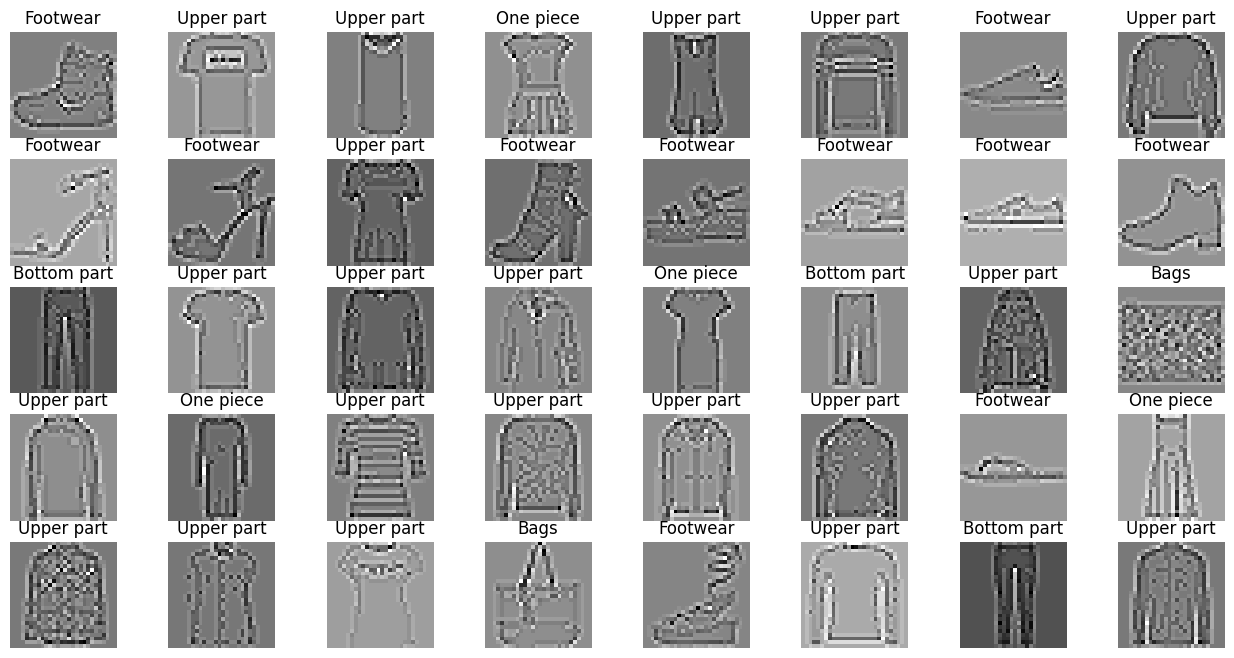

In [3]:
f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255
    ax[i//8, i%8].imshow(laplacian, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


def load_data(path='../data/processed/fashion_mnist_k5.pkl'):
    """
    Load data from pickle file
    """
    with open(path, 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y
        

def cast_and_normalize_images(train, test):
    """
    Convert from integers to floats and normalize to range 0-1
    """
    # Apply sobel filter
    from scipy import ndimage
    for i in range(train.shape[0]):
        img = train[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        train[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255
        

    for i in range(test.shape[0]):
        img = test[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        test[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255

    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm


def get_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [5]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
model_loss = model.history.history['loss']
model_val_loss = model.history.history['val_loss']
plt.plot(model_loss)
plt.plot(model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/model_loss.png')
plt.show()

model_acc = model.history.history['accuracy']
model_val_acc = model.history.history['val_accuracy']
plt.plot(model_acc)
plt.plot(model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/model_acc.png')
plt.show()

# Evaluate model
y_pred = model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


Epoch 1/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.1753 - accuracy: 0.9422 - val_loss: 0.1199 - val_accuracy: 0.9605 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0946 - accuracy: 0.9675 - val_loss: 0.1222 - val_accuracy: 0.9586 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0749 - accuracy: 0.9735 - val_loss: 0.1092 - val_accuracy: 0.9647 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0605 - accuracy: 0.9776 - val_loss: 0.0992 - val_accuracy: 0.9675 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0509 - accuracy: 0.9819 - val_loss: 0.0950 - val_accuracy: 0.9694 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0408 - accuracy: 0.9853 - val_loss: 0.1129 - val_accuracy: 0.9663 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

At the end, the results are slightly worse than the original images.

# Bigger model

In [ ]:
def get_bigger_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_bigger_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


# Small model

In [ ]:
def get_small_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
small_model = get_small_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

small_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

In [ ]:
# Plot loss and accuracy
small_model_loss = small_model.history.history['loss']
small_model_val_loss = small_model.history.history['val_loss']
plt.plot(small_model_loss)
plt.plot(small_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/small_model_loss.png')
plt.show()

small_model_acc = small_model.history.history['accuracy']
small_model_val_acc = small_model.history.history['val_accuracy']
plt.plot(small_model_acc)
plt.plot(small_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../plots/small_model_acc.png')
plt.show()

In [ ]:

# Evaluate model
y_pred = small_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


# 3 plots

In [ ]:
# Plot loss 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(16, 3), sharey=True)

axs[0, 0].plot(big_model_loss)
axs[0, 0].plot(big_model_val_loss)
axs[0, 0].set_title('Big model loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(['Train', 'Test'], loc='upper left')
axs[1, 0].plot(small_model_loss)
axs[1, 0].plot(small_model_val_loss)
axs[1, 0].set_title('Small model loss')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(['Train', 'Test'], loc='upper left')
axs[2, 0].plot(model_loss)
axs[2, 0].plot(model_val_loss)
axs[2, 0].set_title('Baseline model loss')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].legend(['Train', 'Test'], loc='upper left')

axs[0, 1].plot(big_model_acc)
axs[0, 1].plot(big_model_val_acc)
axs[0, 1].set_title('Big model acc')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(['Train', 'Test'], loc='upper left')

# axs[1].plot(small_model_acc)
# axs[1].plot(small_model_val_acc)
# axs[1].set_title('Small model acc')
# axs[1].set_ylabel('Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].legend(['Train', 'Test'], loc='upper left')

# axs[2].plot(model_acc)
# axs[2].plot(model_val_acc)
# axs[2].set_title('Baseline model acc')
# axs[2].set_ylabel('Accuracy')
# axs[2].set_xlabel('Epoch')
# axs[2].legend(['Train', 'Test'], loc='upper left')

plt.savefig('../plots/loss_3_cnn.png')
plt.show()

In [ ]:
# Plot acc 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)

axs[0].plot(big_model_acc)
axs[0].plot(big_model_val_acc)
axs[0].set_title('Big model acc')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

axs[1].plot(small_model_acc)
axs[1].plot(small_model_val_acc)
axs[1].set_title('Small model acc')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

axs[2].plot(model_acc)
axs[2].plot(model_val_acc)
axs[2].set_title('Baseline model acc')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Test'], loc='upper left')

plt.savefig('../plots/accuracy_3_cnn.png')
plt.show()